# IMDB-5000 Dataset Analysis

## Objective: Given information about a movie, predict whether it is terrible, bad, good or great.

### How is this useful?

Developing an accurate model that can predict whether or not a movie would receive a good score from audiences or not would be quite useful for first time film makers who have no idea what kind of resources to invest in their movie. It would also be useful for production companies who want to maximise output of good movies. 

This could also be useful for predicting how good a movie that has not been released yet will be. One could use the model to predict how good an upcoming movie will be and do something with this information, such as win an argument with a friend or even bet on it.

### Dataset

The IMDB-5000 dataset is of size (5043,28), meaning we have 5043 observations (datapoints) and 28 features (variables). The variables are things like:

* Director name
* Duration
* Names of top 3 actors in the movie
* Language

## Part 1: Dataset Exploration

### i) Dealing with NaNs

First we print the shape of the dataset to understand how many variables we are working with. We print the colums to see what each variable is. We will apply some very basic manipulations to remove useless variables and rearrage the data.

Since the 'score' is the dependent variable, it is useful to move this column to the end of the dataset. We also remove the `imdb_movie_link` columns because it is not useful.

We need to know which columns contain `NaN` values as these need to be dealt with. We plot a bar chart displaying how many `NaN` values there are per column.

Dataset shape:  (5043, 28)
Dataset columns:  Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')
Columns with NaN values:
new shape:  (5043, 27)


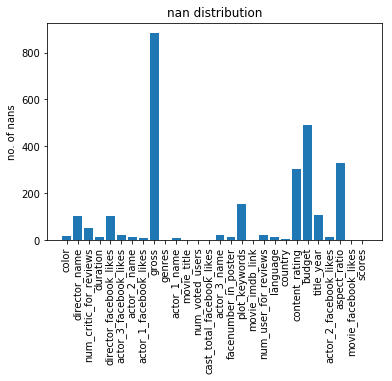

In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# read in the dataset, print shape and column titles
dataset = pd.read_csv('movie_metadata.csv')
print("Dataset shape: ", dataset.shape)
print("Dataset columns: ", dataset.columns)

# move the dependent variable to the end of the dataframe
scores = list(dataset.iloc[:, -3].values)
dataset = dataset.drop(columns='imdb_score')
dataset['scores'] = scores

# count number of NaN values in the columns
print("Columns with NaN values:")
nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append(all_nans[i])

# plot the number of NaN values per column
plt.figure()
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.title('nan distribution')
plt.ylabel('no. of nans')

dataset = dataset.drop(columns='movie_imdb_link')
# we remove all rows where there is no score
dataset = dataset.dropna(axis=0,subset=['scores'])
print("new shape: ", dataset.shape)

From this quick analysis we can see that gross has >10% of rows as NaN. We shall just remove this column instead of attempting to impute values. 

Some of these other columns with a large number of `NaN`s can be reasonably imputed, such as budget and aspect ratio. For the former we can set `NaN`s to the median of the column and for aspect ratio we can set `NaN`s to the most frequent value of the column.

For the rest of the colums, there are not many `NaNs` so we will simply delete these datapoints. This results in a dataset with 4857 rows.

shape of data before:  (5043, 27)
shape of data after:  (4857, 15)


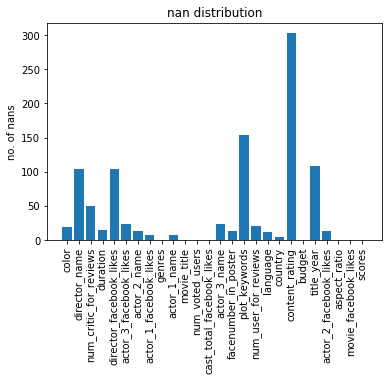

In [50]:
print("shape of data before: ", dataset.shape)

# Taking care of missing data
dataset = dataset.drop(columns='gross')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(np.asarray(dataset['budget']).reshape(-1,1))
dataset['budget'] = imputer.transform(np.asarray(dataset['budget']).reshape(-1,1))

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(np.asarray(dataset['aspect_ratio']).reshape(-1,1))
dataset['aspect_ratio'] = imputer.transform(np.asarray(dataset['aspect_ratio']).reshape(-1,1))

nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append(all_nans[i])

# plot the number of NaN values per column
plt.figure()
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.title('nan distribution')
plt.ylabel('no. of nans')

dataset = dataset.drop(columns=['color','plot_keywords','director_name','genres','movie_title','actor_1_name','actor_2_name','actor_3_name','language','country','content_rating'])

dataset = dataset.dropna(axis=0)
print("shape of data after: ", dataset.shape)

### ii) Removing highly correlated features

Features that are highly co-correlated are redundant and are not useful, so we can remove them. We compute the correlation matrix for all of the variables and we will remove all variables that are correlated with correlation coefficient > 0.7.

In [51]:
from sklearn.feature_selection import VarianceThreshold

correlated_features = set()
correlation_matrix = dataset.corr()

print(correlation_matrix)

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(len(correlated_features))
print(correlated_features)

dataset.drop(labels=correlated_features, axis=1, inplace=True)
print(dataset.columns)

                           num_critic_for_reviews  duration  \
num_critic_for_reviews                   1.000000  0.250218   
duration                                 0.250218  1.000000   
director_facebook_likes                  0.180829  0.173041   
actor_3_facebook_likes                   0.271381  0.131500   
actor_1_facebook_likes                   0.185841  0.081611   
num_voted_users                          0.622799  0.338775   
cast_total_facebook_likes                0.259086  0.119185   
facenumber_in_poster                    -0.030158  0.028558   
num_user_for_reviews                     0.605108  0.351489   
budget                                   0.120056  0.073439   
title_year                               0.280223 -0.132171   
actor_2_facebook_likes                   0.280324  0.135727   
aspect_ratio                             0.027533  0.051923   
movie_facebook_likes                     0.688355  0.213349   
scores                                   0.334491  0.35

We find from this analysis that `num_user_for_reviews`, which is correlated with `num_voted_users` and `cast_total_facebook_likes`, which is highly correlated with `actor_1_facebook_likes`.

Therefore, we drop the `num_user_for_reviews` and `cast_total_facebook_likes` columns.

## Part 2: Dataset Preprocessing

### i) Categorising the dependent variable

We are not attempting to predict exact scores, we would like to classify movies into categories depending on how good they are. In order for this to work we need to convert the dependent variable (scores) into categories.

We do this by defining ranges for the scores that define how good they are.

Text(0, 0.5, 'no. of movies')

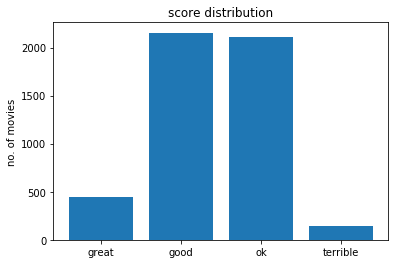

In [52]:
# put the score columns into categories
scores = list(dataset['scores'])
dataset.drop(columns='scores')
score_classes = []

for score in scores:
    if score >= 1.6 and score < 4.0:
        score_classes.append("terrible")
    elif score >= 4.0 and score < 6.5:
        score_classes.append("ok")
    elif score >= 6.5 and score < 7.8:
        score_classes.append("good")
    elif score >= 7.8 and score < 10.0:
        score_classes.append("great")
        
dataset['scores'] = score_classes

from collections import Counter
scores = Counter(list(dataset['scores']))

# plot the number of NaN values per column
plt.figure()
plt.bar(scores.keys(), scores.values())
plt.xticks([i for i in range(len(list(scores.keys())))], list(scores.keys()),)
plt.title('score distribution')
plt.ylabel('no. of movies')

### ii) Split the data into independent and dependent variables

In [53]:
print(dataset.columns)

X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

# Encoding the Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_le = le.fit_transform(y)

"""
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
"""
"""
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1,1)).toarray()
print(X.shape)
print(y.shape)
"""

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'facenumber_in_poster', 'budget', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
       'scores'],
      dtype='object')


'\nfrom sklearn.preprocessing import OneHotEncoder\nohe = OneHotEncoder()\ny = ohe.fit_transform(y.reshape(-1,1)).toarray()\nprint(X.shape)\nprint(y.shape)\n'

### iii) Apply feature scaling

In [54]:
# Feature Scaling (necessary for NNs)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

### iv) Split the dataset into training and test set with ration 90:10

In [55]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size = 0.1, random_state = 0)

## Part 3: Model training

### i) Naive Bayes

We will compare several models, the first of which is the Naive Bayes classifier, as it is the simplest model.

We achive an accuracy of 31% on the test set, which is very low.

In [56]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)

y_pred = NB.predict(X_test)

from sklearn.metrics import accuracy_score
a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy is: 31.275720164609055
[[ 40  26  65  74]
 [ 15  25   6   5]
 [ 14   4  70 123]
 [  1   0   1  17]]


### ii) K-Nearest Neighbours

We now attempy a KNN classifier using Euclidean distance and 5 neighbours, achieving an accuracy of 58.5%, which is a significant improvement on the Naive Bayes.

In [57]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy is: 58.8477366255144
[[131   6  67   1]
 [ 25  20   6   0]
 [ 76   0 135   0]
 [  5   0  14   0]]


### iii) Support Vector Machine

Using an SVM classifier, we achieve a slight improvement on the KNN classifier, with an accuracy of 63.9%

In [58]:
# Training the Kernel SVM model on the Training set
from sklearn.svm import SVC
SVM = SVC(kernel = 'rbf', random_state = 0)
SVM.fit(X_train, y_train)

y_pred = SVM.predict(X_test)

a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix, f1_score
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy is: 63.991769547325106
[[129   2  74   0]
 [ 32  15   4   0]
 [ 44   0 167   0]
 [  2   0  17   0]]


### iv) Random Forest Classifier

Lastly of the classical methods, we fit a Random Forest Classifier, achieving a slightly better accuracy of 65.6%.

In [59]:
# Training the Random Forest Classification model on the Training set
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', random_state = 0)
RFC.fit(X_train, y_train)

y_pred = RFC.predict(X_test)

a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy is: 65.63786008230453
[[135   4  66   0]
 [ 29  22   0   0]
 [ 50   0 161   0]
 [  1   0  17   1]]


### v) Neural Network

In order to use a neural network the dependent variable must be onehotencoded.

We then define the neural network, which has 3 hidden layers and train with a batch size of 16 for 200 epochs.

We achieve an accuracy of 67.9% on the test set, which is the highest of all the methods explored.

In [65]:
from sklearn.preprocessing import OneHotEncoder
print(y.shape)
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y.reshape(-1,1)).toarray()
print(y_ohe.shape)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.1, random_state = 0)

(4857,)
(4857, 4)


In [69]:
# Create ANN
import keras
from keras.models import Sequential
from keras.layers import Dense

# initialise the ANN
Net = Sequential()

# Add input layer + first hidden layer
Net.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))

# Add second & third hidden layers
Net.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))
Net.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Add the output layer
Net.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compile the Neural Network
Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [70]:
# fit ANN to the training set
history = Net.fit(X_train, y_train, batch_size = 16, validation_data = (X_test,y_test), epochs = 200)

Train on 4371 samples, validate on 486 samples
Epoch 1/200
4371/4371 [==============================] - 1s 148us/step - loss: 1.1572 - accuracy: 0.4365 - val_loss: 1.0574 - val_accuracy: 0.4280
Epoch 2/200
4371/4371 [==============================] - 0s 61us/step - loss: 0.9960 - accuracy: 0.4484 - val_loss: 1.0394 - val_accuracy: 0.4218
Epoch 3/200
4371/4371 [==============================] - 0s 67us/step - loss: 0.9569 - accuracy: 0.4681 - val_loss: 0.9677 - val_accuracy: 0.4568
Epoch 4/200
4371/4371 [==============================] - 0s 63us/step - loss: 0.8971 - accuracy: 0.4823 - val_loss: 0.9163 - val_accuracy: 0.4733
Epoch 5/200
4371/4371 [==============================] - 0s 81us/step - loss: 0.8644 - accuracy: 0.6088 - val_loss: 0.8833 - val_accuracy: 0.5967
Epoch 6/200
4371/4371 [==============================] - 0s 64us/step - loss: 0.8404 - accuracy: 0.6129 - val_loss: 0.8701 - val_accuracy: 0.6049
Epoch 7/200
4371/4371 [==============================] - 0s 72us/step - loss

4371/4371 [==============================] - 0s 63us/step - loss: 0.7523 - accuracy: 0.6664 - val_loss: 0.7973 - val_accuracy: 0.6605
Epoch 57/200
4371/4371 [==============================] - 0s 56us/step - loss: 0.7521 - accuracy: 0.6680 - val_loss: 0.7973 - val_accuracy: 0.6626
Epoch 58/200
4371/4371 [==============================] - 0s 55us/step - loss: 0.7532 - accuracy: 0.6651 - val_loss: 0.7945 - val_accuracy: 0.6708
Epoch 59/200
4371/4371 [==============================] - 0s 55us/step - loss: 0.7498 - accuracy: 0.6680 - val_loss: 0.7978 - val_accuracy: 0.6564
Epoch 60/200
4371/4371 [==============================] - 0s 56us/step - loss: 0.7507 - accuracy: 0.6756 - val_loss: 0.8061 - val_accuracy: 0.6646
Epoch 61/200
4371/4371 [==============================] - 0s 55us/step - loss: 0.7506 - accuracy: 0.6712 - val_loss: 0.8010 - val_accuracy: 0.6605
Epoch 62/200
4371/4371 [==============================] - 0s 59us/step - loss: 0.7503 - accuracy: 0.6733 - val_loss: 0.7978 - val_a

Epoch 112/200
4371/4371 [==============================] - 0s 63us/step - loss: 0.7411 - accuracy: 0.6799 - val_loss: 0.8166 - val_accuracy: 0.6646
Epoch 113/200
4371/4371 [==============================] - 0s 70us/step - loss: 0.7381 - accuracy: 0.6754 - val_loss: 0.8123 - val_accuracy: 0.6687
Epoch 114/200
4371/4371 [==============================] - 0s 58us/step - loss: 0.7379 - accuracy: 0.6783 - val_loss: 0.8163 - val_accuracy: 0.6626
Epoch 115/200
4371/4371 [==============================] - 0s 59us/step - loss: 0.7399 - accuracy: 0.6767 - val_loss: 0.7969 - val_accuracy: 0.6728
Epoch 116/200
4371/4371 [==============================] - 0s 69us/step - loss: 0.7370 - accuracy: 0.6802 - val_loss: 0.8195 - val_accuracy: 0.6728
Epoch 117/200
4371/4371 [==============================] - 0s 61us/step - loss: 0.7374 - accuracy: 0.6760 - val_loss: 0.8093 - val_accuracy: 0.6687
Epoch 118/200
4371/4371 [==============================] - 0s 66us/step - loss: 0.7395 - accuracy: 0.6776 - val_

4371/4371 [==============================] - 0s 68us/step - loss: 0.7319 - accuracy: 0.6820 - val_loss: 0.7982 - val_accuracy: 0.6584
Epoch 168/200
4371/4371 [==============================] - 0s 61us/step - loss: 0.7293 - accuracy: 0.6822 - val_loss: 0.7966 - val_accuracy: 0.6646
Epoch 169/200
4371/4371 [==============================] - 0s 60us/step - loss: 0.7276 - accuracy: 0.6825 - val_loss: 0.7959 - val_accuracy: 0.6687
Epoch 170/200
4371/4371 [==============================] - 0s 60us/step - loss: 0.7315 - accuracy: 0.6797 - val_loss: 0.8120 - val_accuracy: 0.6626
Epoch 171/200
4371/4371 [==============================] - 0s 60us/step - loss: 0.7308 - accuracy: 0.6834 - val_loss: 0.8139 - val_accuracy: 0.6502
Epoch 172/200
4371/4371 [==============================] - 0s 62us/step - loss: 0.7289 - accuracy: 0.6811 - val_loss: 0.8022 - val_accuracy: 0.6708
Epoch 173/200
4371/4371 [==============================] - 0s 69us/step - loss: 0.7299 - accuracy: 0.6815 - val_loss: 0.8050 -

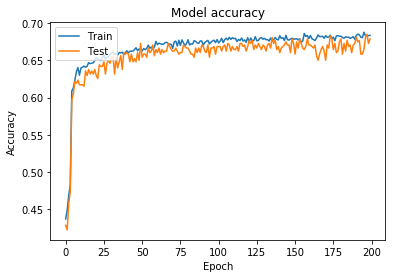

[[127   4  74   0]
 [ 20  29   2   0]
 [ 36   1 174   0]
 [  2   0  17   0]]
Accuracy is: 67.90123456790124


In [71]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

y_pred = Net.predict(X_test)

# Converting predictions to label
pred_classes = list()
for i in range(len(y_pred)):
    pred_classes.append(np.argmax(y_pred[i]))

# Converting one hot encoded test label to label
test_classes = list()
for i in range(len(y_test)):
    test_classes.append(np.argmax(y_test[i]))

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_classes, pred_classes)
print(confusion)

from sklearn.metrics import accuracy_score
a = accuracy_score(pred_classes,test_classes)
print('Accuracy is:', a*100)